## Import Required Libraries

In [7]:
import os
import re
import pandas as pd
import pickle
from bs4 import BeautifulSoup
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from email import policy
from email.parser import BytesParser
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Load Model

In [ ]:
model = load_model('spam_cnn_saved_model')  

# Load the Tokenizer fit on the training data
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

## Predict Spam Emails


In [9]:

# Safely get text from email parts
def safe_get_text(part):
    """Try get_content(); if it fails, decode payload as utf-8 (ignore errors)."""
    try:
        return part.get_content()
    except LookupError:
        raw = part.get_payload(decode=True) or b''
        charset = part.get_content_charset() or 'utf-8'
        try:
            return raw.decode(charset, errors='ignore')
        except (LookupError, UnicodeDecodeError):
            return raw.decode('latin-1', errors='ignore')

# Replace URLs and bare domains with <URL>
def replace_links(text):
    """Substitute all URLs and bare-domain patterns with the placeholder '<URL>'."""
    text = re.sub(r'https?://\S+|www\.\S+', '<URL>', text)
    text = re.sub(
        r'\b[\w\.-]+\.(com|org|net|edu|gov|io|co)(/[^\s]*)?\b',
        '<URL>',
        text
    )
    return text

# Extract text from .eml files
def extract_text_from_eml(path):
    """Parse .eml → Subject + cleaned body (HTML stripped, links replaced, lowercase, whitespace normalized)."""
    with open(path, 'rb') as f:
        msg = BytesParser(policy=policy.default).parse(f)

    parts = []
    # Subject
    if msg['Subject']:
        parts.append(str(msg['Subject']))

    # Body (plain + HTML)
    for part in msg.walk():
        ctype = part.get_content_type()
        if ctype == 'text/plain':
            parts.append(safe_get_text(part))
        elif ctype == 'text/html':
            html = safe_get_text(part)
            parts.append(BeautifulSoup(html, "html.parser").get_text())

    # 1) Join, 2) lowercase, 3) collapse whitespace
    text = ' '.join(parts).lower()
    text = re.sub(r'\s+', ' ', text).strip()

    # Replace all links/domains with <URL>
    text = replace_links(text)

    return text

# Preprocess the text for the model
def preprocess_email(text, max_len=600):
    """
    Tokenize & pad a raw cleaned text. 
    Assumes `text` has already been run through extract_text_from_eml().
    """
    seq = tokenizer.texts_to_sequences([text])
    return pad_sequences(seq,
                         maxlen=max_len,
                         padding='post',
                         truncating='post')

1/1 [==============================] - 0s 26ms/step
Merged df shape: (230, 6)
Confusion Matrix:
 [[100   0]
 [ 21 109]]

Classification Report:
               precision    recall  f1-score   support

         Ham       0.83      1.00      0.90       100
        Spam       1.00      0.84      0.91       130

    accuracy                           0.91       230
   macro avg       0.91      0.92      0.91       230
weighted avg       0.92      0.91      0.91       230



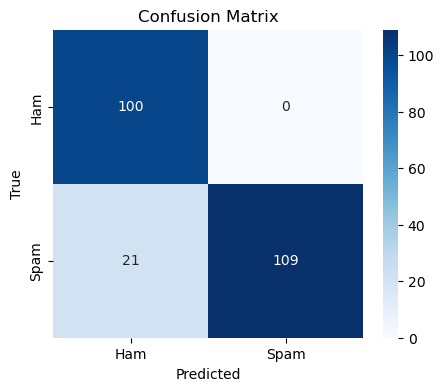


False Negatives:
                                 file_name_x result true_label  probability
104                              Spam102.eml    Ham       Spam     0.503402
107                              Spam105.eml    Ham       Spam     0.452182
109                              Spam107.eml    Ham       Spam     0.094379
110                              Spam108.eml    Ham       Spam     0.038793
111                              Spam109.eml    Ham       Spam     0.065365
113                              Spam110.eml    Ham       Spam     0.068863
114                              Spam111.eml    Ham       Spam     0.020264
115                              Spam112.eml    Ham       Spam     0.532519
117                              Spam114.eml    Ham       Spam     0.038439
118                              Spam115.eml    Ham       Spam     0.021920
119                              Spam116.eml    Ham       Spam     0.019329
122                              Spam119.eml    Ham       Spam     0.1

In [ ]:
folder_path = 'data/test'

# Iterate through all files in the folder
results = []

for fname in sorted(os.listdir(folder_path)):
    fullpath = os.path.join(folder_path, fname)
    raw_text = extract_text_from_eml(fullpath)
    x = preprocess_email(raw_text)
    prob = float(model.predict(x)[0][0])
    label = 'Spam' if prob > 0.63 else 'Ham'
    results.append({
        'file_name': fname,
        'result':    label,
        'probability': prob
    })


df_results = pd.DataFrame(results)

# 2) Manually parse ground_truth.csv
gt_path = os.path.join(folder_path, 'ground_truth.csv')
gt = pd.read_csv(gt_path, dtype=str)  

df_results['base_name'] = df_results['file_name'].str.split(pat='.', n=1).str[0]

# now merge using that
df = df_results.merge(
    gt,
    left_on='base_name',
    right_on='file_name',
    how='inner'           # default is inner, but being explicit helps
)
print("Merged df shape:", df.shape)


# 3) Merge & evaluate
label_map = {'Ham':0, 'Spam':1}
y_true = df['true_label'].map(label_map)
y_pred = df['result'].map(label_map)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n",
    classification_report(
        y_true,
        y_pred,
        labels=[0, 1],
        target_names=['Ham', 'Spam'],
        zero_division=0
    ))


# 4) Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

# 5) Show all predictions if like
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Show false negatives
print("\nFalse Negatives:")
print(df[(y_true == 1) & (y_pred == 0)][['file_name_x', 'result', 'true_label', 'probability']])

